# Classification

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import numpy as np 
from class_functions import *
import pandas as pd
import sklearn

np.random.seed(1234)
root_dir = "/home/alberto_sinigaglia/gaia"

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1762351337.175096 1134213 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44560 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


In [3]:
def basic_block(x, kernel_size, filters, reg_rate, drop_rate, name, pool_size=2):
    """Single Conv1D layer with ReLU activation + global avarage pooling"""

    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(reg_rate), name=f'{name}_conv')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1, name=f"{name}_leaky_relu")(x)
    x = tf.keras.layers.Dropout(drop_rate, name=f'{name}_dropout')(x)
    x = tf.keras.layers.AveragePooling1D(pool_size,  name=f'{name}_avgpooling')(x)
    return x
    
def residual_block(x, kernel_size, filters, reg_rate, name):

    shortcut = x 
    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(reg_rate), name=f'{name}_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name=f'{name}_bn1')(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1, name=f"{name}_leaky_relu1")(x)
    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None,  kernel_regularizer=tf.keras.regularizers.l2(reg_rate), name=f'{name}_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name=f'{name}_bn2')(x)
    x = tf.keras.layers.Add( name=f'{name}_add')([shortcut, x])
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1, name=f"{name}_leaky_relu2")(x)
    return x

def build_model(reg_rate, drop_rate, input_length=6144, channels=1, filters=42):

    inp = tf.keras.layers.Input(shape=(input_length, channels), name='input_layer')

    x = basic_block(inp, 16, filters, reg_rate, drop_rate, name='bb_1')
    x = residual_block(x, 16, filters, reg_rate, name='rb_1')

    x = basic_block(x, 32, filters, reg_rate, drop_rate, name='bb_2')
    x = residual_block(x, 32, filters, reg_rate, name='rb_2')

    x = basic_block(x, 64, filters, reg_rate, drop_rate, name='bb_3')
    x = residual_block(x, 64, filters, reg_rate, name='rb_3')

    x = basic_block(x, 64, filters, reg_rate, drop_rate, name='bb_4')

    x = tf.keras.layers.GlobalAveragePooling1D(name='global_avg_pool')(x)

    #x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_1')(x)
    #x = tf.keras.layers.Dropout(drop_rate, name='prova_1')(x)
    #x = tf.keras.layers.Dense(64,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_2')(x)
    #x = tf.keras.layers.Dropout(drop_rate, name='iprova_2')(x)
    x = tf.keras.layers.Dense(64,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_rate), name='dl_3')(x)
    x = tf.keras.layers.Dropout(drop_rate, name='dropout_1')(x)
    x = tf.keras.layers.Dense(32,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_rate), name='dl_4')(x)
    x = tf.keras.layers.Dropout(drop_rate, name='dropout_2')(x)

    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(x)

    model =  tf.keras.Model(inp, out, name='regression_model')
    return model

In [4]:
'''
def basic_block(x, kernel_size, filters, name, pool_size=2):
    """Single Conv1D layer with ReLU activation + global avarage pooling"""

    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-4), name=f'{name}_conv')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1, name=f"{name}_leaky_relu")(x)
    x = tf.keras.layers.AveragePooling1D(pool_size,  name=f'{name}_avgpooling')(x)
    return x
    
def residual_block(x, kernel_size, filters, name):

    shortcut = x 
    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-4), name=f'{name}_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name=f'{name}_bn1')(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1, name=f"{name}_leaky_relu1")(x)
    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None,  kernel_regularizer=tf.keras.regularizers.l2(1e-4), name=f'{name}_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name=f'{name}_bn2')(x)
    x = tf.keras.layers.Add( name=f'{name}_add')([shortcut, x])
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1, name=f"{name}_leaky_relu2")(x)
    return x

def build_model(input_length=6144, channels=1, filters=42):

    inp = tf.keras.layers.Input(shape=(input_length, channels), name='input_layer')

    x = basic_block(inp, 16, filters, name='bb_1')
    x = residual_block(x, 16, filters, name='rb_1')

    x = basic_block(x, 32, filters, name='bb_2')
    x = residual_block(x, 32, filters, name='rb_2')

    x = basic_block(x, 64, filters, name='bb_3')
    x =  residual_block(x, 64, filters, name='rb_3')

    x = basic_block(x, 64, filters, name='bb_4')

    x = tf.keras.layers.Flatten(name='flatten_layer')(x)

    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout_1')(x)
    x = tf.keras.layers.Dense(64,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_2')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout_2')(x)
    x = tf.keras.layers.Dense(64,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_3')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout_3')(x)
    x = tf.keras.layers.Dense(32,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_4')(x)

    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(x)

    model =  tf.keras.Model(inp, out, name='classification_model')
    return model

model = build_model()
model.summary()


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), 
                       tf.keras.metrics.TruePositives(name="true_positives"),
                       tf.keras.metrics.FalsePositives(name="false_positives"),
                       tf.keras.metrics.Recall(name="recall")])

                       
'''

'\ndef basic_block(x, kernel_size, filters, name, pool_size=2):\n    """Single Conv1D layer with ReLU activation + global avarage pooling"""\n\n    x = tf.keras.layers.Conv1D(filters, kernel_size, padding=\'same\', activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-4), name=f\'{name}_conv\')(x)\n    x = tf.keras.layers.LeakyReLU(alpha=0.1, name=f"{name}_leaky_relu")(x)\n    x = tf.keras.layers.AveragePooling1D(pool_size,  name=f\'{name}_avgpooling\')(x)\n    return x\n    \ndef residual_block(x, kernel_size, filters, name):\n\n    shortcut = x \n    x = tf.keras.layers.Conv1D(filters, kernel_size, padding=\'same\', activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-4), name=f\'{name}_conv1\')(x)\n    x = tf.keras.layers.BatchNormalization(name=f\'{name}_bn1\')(x)\n    x = tf.keras.layers.LeakyReLU(negative_slope=0.1, name=f"{name}_leaky_relu1")(x)\n    x = tf.keras.layers.Conv1D(filters, kernel_size, padding=\'same\', activation=None,  kernel_regularizer=tf.ke

## Low Mass model

We load the low mass range dataset, and proceed to train the newtork. We save the best model by choosing the one with the lowest validation loss. To focus on maximizing the true positives, but still striking a balance with the false positives, I choose as threshold 0.4.

In [3]:
mass_range = "CNN_low_mass"

train_path = f"{root_dir}/{mass_range}_train.npz"
test_path = f"{root_dir}/{mass_range}_test.npz"

with np.load(train_path, allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]

X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)

with np.load(test_path, allow_pickle=True) as data:
    X_test = data["X"]
    y_test = data["y"]

train_dataset = make_dataset(X_train, y_train, classification=True, batch_size=64)
val_dataset = make_dataset(X_val, y_val, classification=True, batch_size=64)
test_dataset = make_dataset(X_test, y_test, classification=True, batch_size=64, shuffle=False)

In [36]:
model = build_model(reg_rate=1e-4, drop_rate=0.3)

total_steps = 5808 // 128 * 150  # Assuming 5808 training samples, batch size 64, for 50 epochs
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5,
    decay_steps=total_steps,
    alpha=1e-6
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=5.0),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), 
                       tf.keras.metrics.TruePositives(name="true_positives"),
                       tf.keras.metrics.FalsePositives(name="false_positives"),
                       tf.keras.metrics.Recall(name="recall")])

/home/alberto_sinigaglia/anaconda3/envs/gaia/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [4]:
model_path = f"class_models/{mass_range}_best_model.keras"
logger_path = f"class_models/training_log_{mass_range}.csv"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, 
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename=logger_path,
        append=False,
    )
]

In [ ]:
'''
history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1,
)
'''

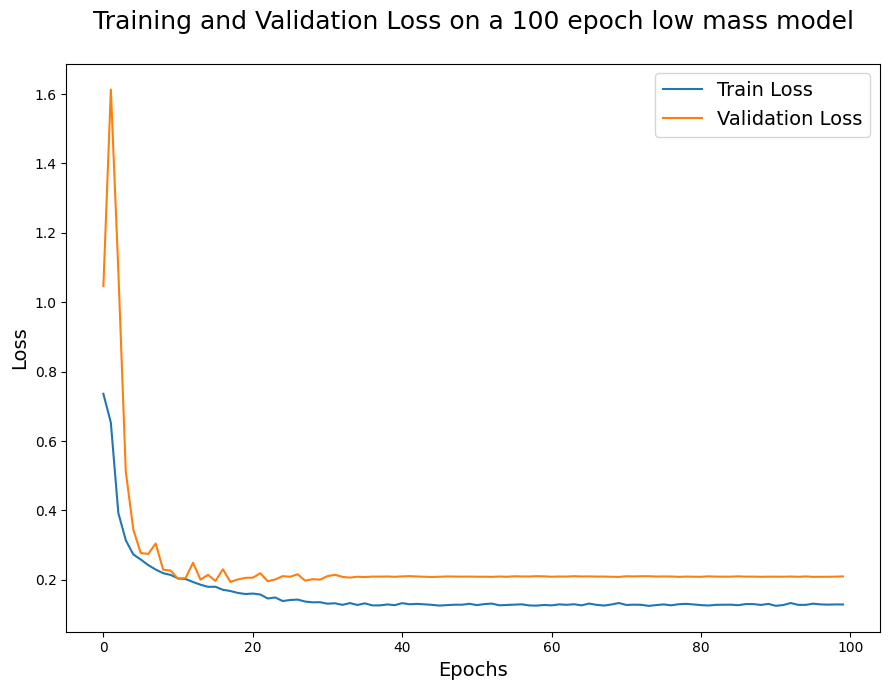

In [51]:
logger = pd.read_csv(logger_path)
train_loss = logger['loss'].values
val_loss = logger['val_loss'].values

plt.figure(figsize=(9,7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.title('Training and Validation Loss on a 100 epoch low mass model',
          fontsize=18, pad=25)

plt.legend(fontsize=14, loc='best')

plt.tight_layout()
plt.show()

In [5]:
model = tf.keras.models.load_model(model_path)

y_test_pred = model.predict(X_test)
pred = (y_test_pred > 0.4).astype(int)

#loss, acc, tp, fp, recall = model.evaluate(test_dataset)
acc = sklearn.metrics.accuracy_score(y_test[:,0].astype(np.float64), pred)
precision = sklearn.metrics.precision_score(y_test[:,0].astype(np.float64), pred)
recall = sklearn.metrics.recall_score(y_test[:,0].astype(np.float64), pred)
roc_auc = sklearn.metrics.roc_auc_score(y_test[:,0].astype(np.float64), y_test_pred)

print('Test Accuracy: {:.2f}%'.format(acc * 100))
print('Test Precision: {:.2f}%'.format(precision * 100))
print('Test Recall: {:.2f}%'.format(recall * 100))
print('Test ROC AUC: {:.4f}'.format(roc_auc))

33/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

I0000 00:00:1762350621.829495 1128477 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Test Accuracy: 94.79%
Test Precision: 93.94%
Test Recall: 95.76%
Test ROC AUC: 0.9896


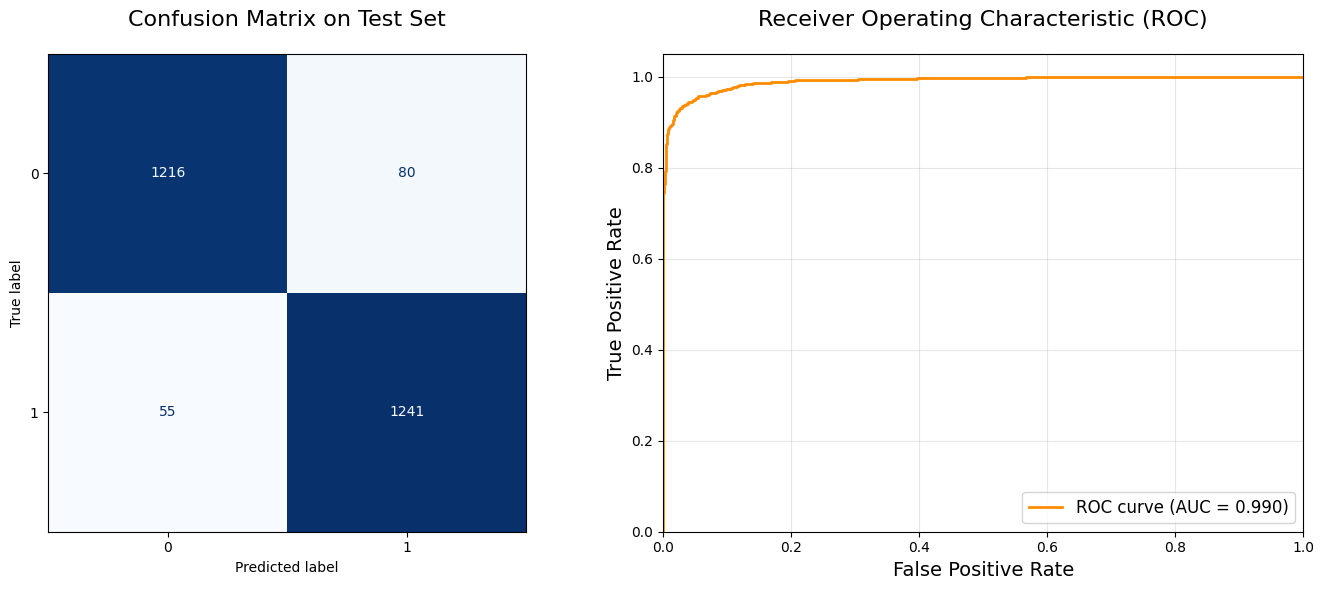

In [6]:
cm = sklearn.metrics.confusion_matrix(y_test[:,0].astype(np.float64), pred)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test[:,0].astype(np.float64), y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix on Test Set', fontsize=16, pad=20)


axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

axes[1].set_xlabel('False Positive Rate', fontsize=14)
axes[1].set_ylabel('True Positive Rate', fontsize=14)
axes[1].set_title('Receiver Operating Characteristic (ROC)', fontsize=16, pad=20)
axes[1].legend(loc='lower right', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

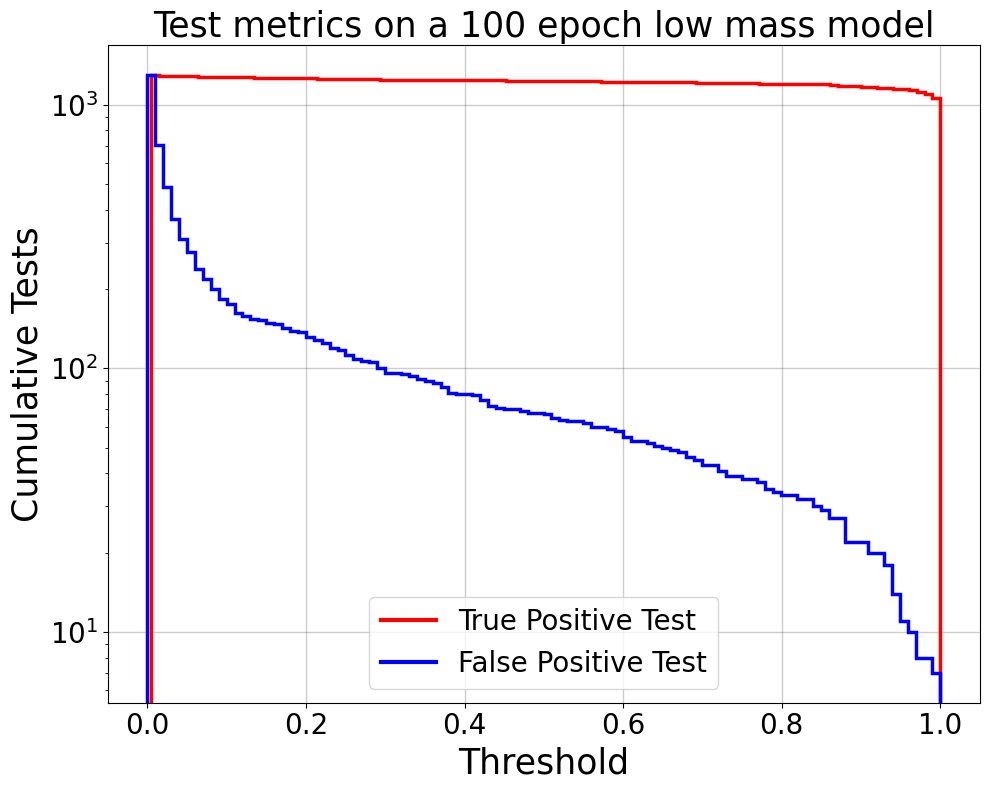

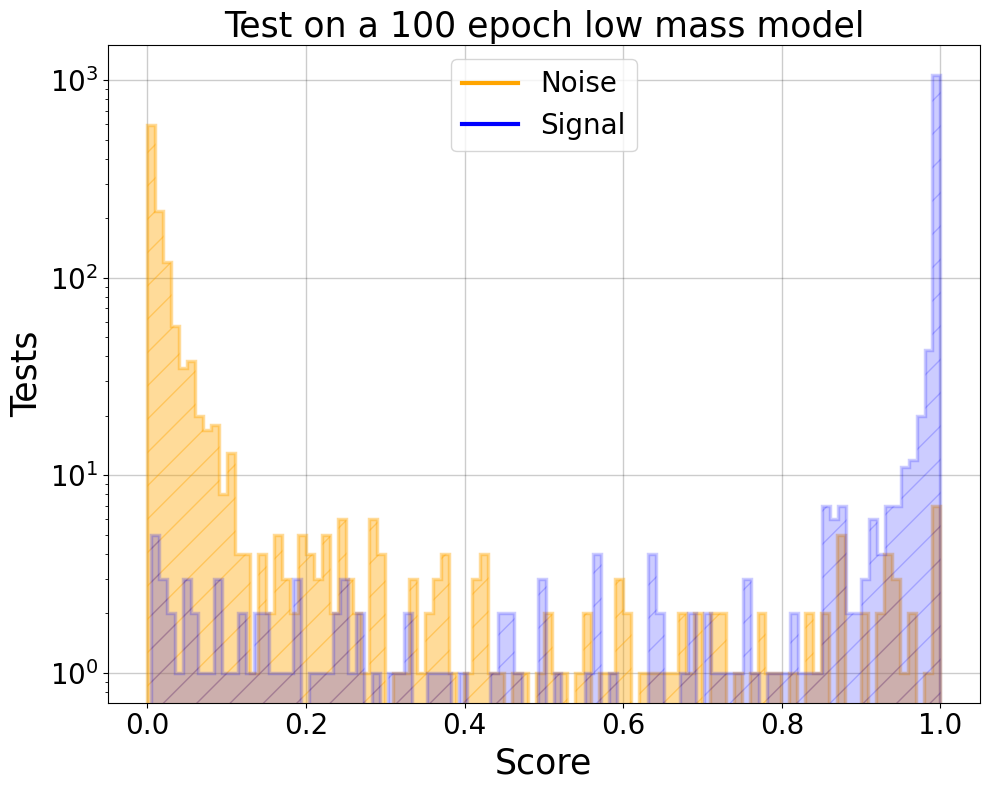

In [101]:
plot_tp_fp(y_test_pred, title='Test metrics on a 100 epoch low mass model')
plot_signal_noise(y_test_pred, title='Test on a 100 epoch low mass model')

## Mid Mass I Model 

In [102]:
mass_range = "CNN_mid_mass_I"

train_path = f"{root_dir}/{mass_range}_train.npz"
test_path = f"{root_dir}/{mass_range}_test.npz"

with np.load(train_path, allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]

X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)

with np.load(test_path, allow_pickle=True) as data:
    X_test = data["X"]
    y_test = data["y"]

train_dataset = make_dataset(X_train, y_train, classification=True, batch_size=64)
val_dataset = make_dataset(X_val, y_val, classification=True, batch_size=64)
test_dataset = make_dataset(X_test, y_test, classification=True, batch_size=64, shuffle=False)

In [103]:
model_path = f"class_models/{mass_range}_best_model.keras"
logger_path = f"class_models/training_log_{mass_range}.csv"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, 
        monitor="val_acc",
        mode="max",
        save_best_only=True,
        verbose=0,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename=logger_path,
        append=False,
    )
]

In [63]:
model = build_model(reg_rate=1e-4, drop_rate=0.3)

total_steps = 5808 // 128 * 150  # Assuming 5808 training samples, batch size 64, for 50 epochs
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5,
    decay_steps=total_steps,
    alpha=1e-6
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=5.0),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), 
                       tf.keras.metrics.TruePositives(name="true_positives"),
                       tf.keras.metrics.FalsePositives(name="false_positives"),
                       tf.keras.metrics.Recall(name="recall")])

/home/alberto_sinigaglia/anaconda3/envs/gaia/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
'''
history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1,
)
'''

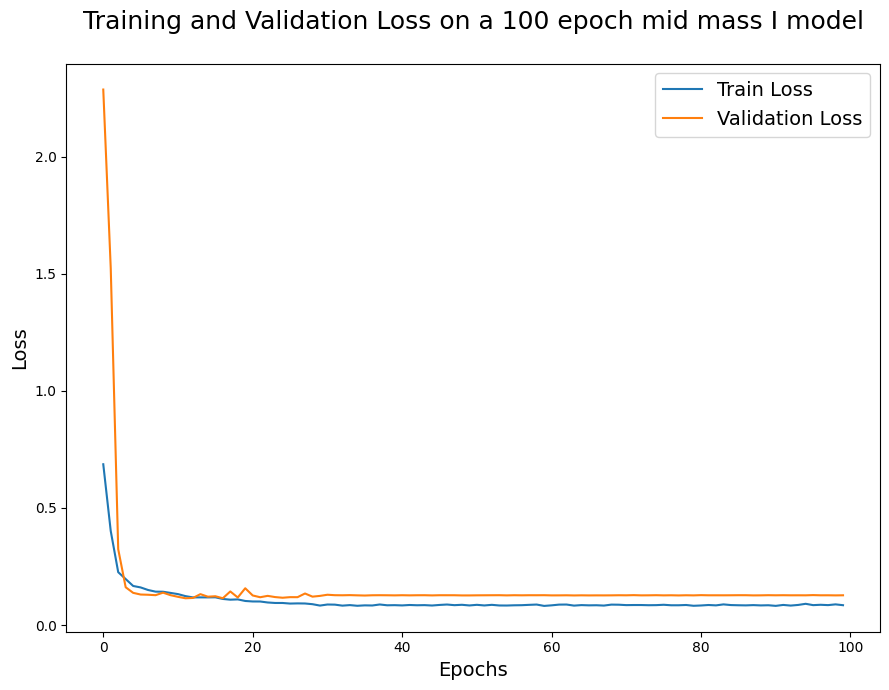

In [71]:
logger = pd.read_csv(logger_path)
train_loss = logger['loss'].values
val_loss = logger['val_loss'].values

plt.figure(figsize=(9,7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.title('Training and Validation Loss on a 100 epoch mid mass I model',
          fontsize=18, pad=25)

plt.legend(fontsize=14, loc='best')

plt.tight_layout()
plt.show()

In [104]:
model = tf.keras.models.load_model(model_path)

y_test_pred = model.predict(X_test)
pred = (y_test_pred > 0.2).astype(int)

#loss, acc, tp, fp, recall = model.evaluate(test_dataset)
acc = sklearn.metrics.accuracy_score(y_test[:,0].astype(np.float64).astype(np.float64), pred)
precision = sklearn.metrics.precision_score(y_test[:,0].astype(np.float64), pred)
recall = sklearn.metrics.recall_score(y_test[:,0].astype(np.float64), pred)
roc_auc = sklearn.metrics.roc_auc_score(y_test[:,0].astype(np.float64), y_test_pred)

print('Test Accuracy: {:.2f}%'.format(acc * 100))
print('Test Precision: {:.2f}%'.format(precision * 100))
print('Test Recall: {:.2f}%'.format(recall * 100))
print('Test ROC AUC: {:.4f}'.format(roc_auc))

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Accuracy: 97.72%
Test Precision: 96.68%
Test Recall: 98.84%
Test ROC AUC: 0.9980


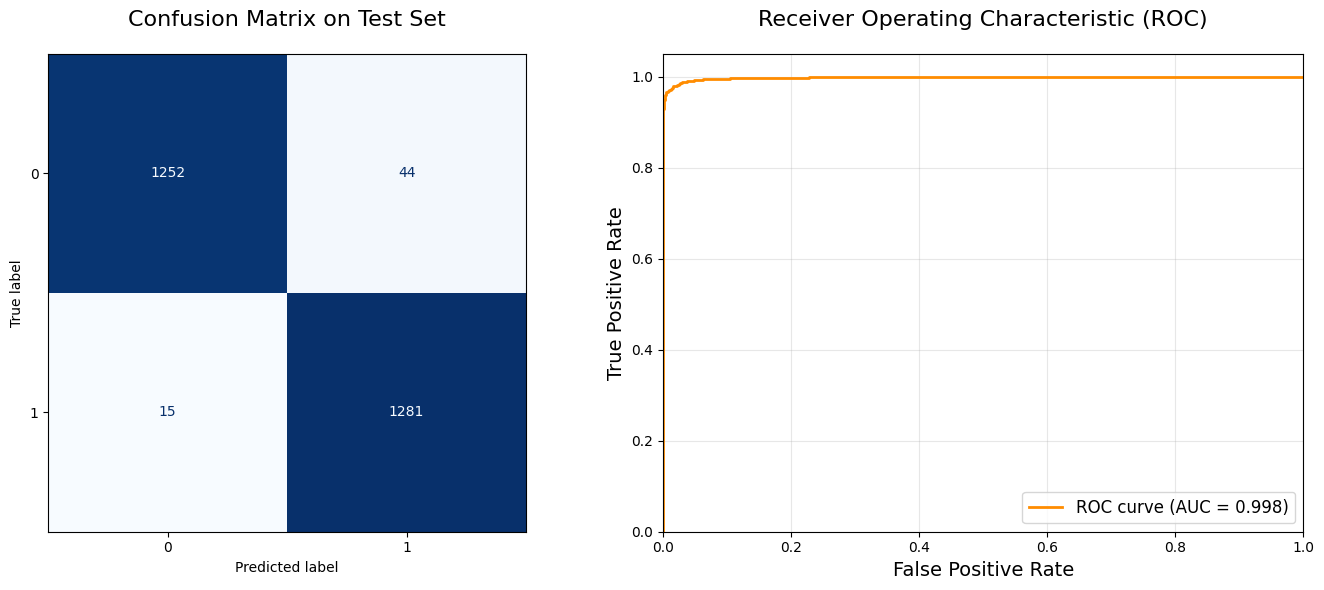

In [76]:
cm = sklearn.metrics.confusion_matrix(y_test[:,0].astype(np.float64), pred)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test[:,0].astype(np.float64), y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix on Test Set', fontsize=16, pad=20)


axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=14)
axes[1].set_ylabel('True Positive Rate', fontsize=14)
axes[1].set_title('Receiver Operating Characteristic (ROC)', fontsize=16, pad=20)
axes[1].legend(loc='lower right', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

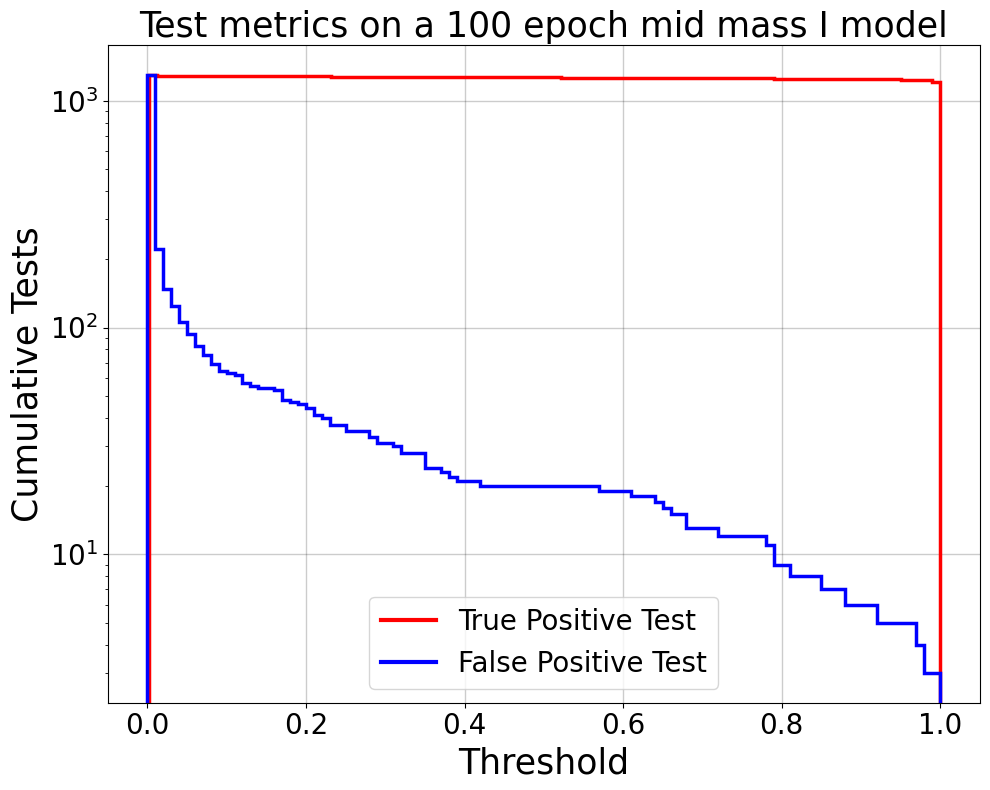

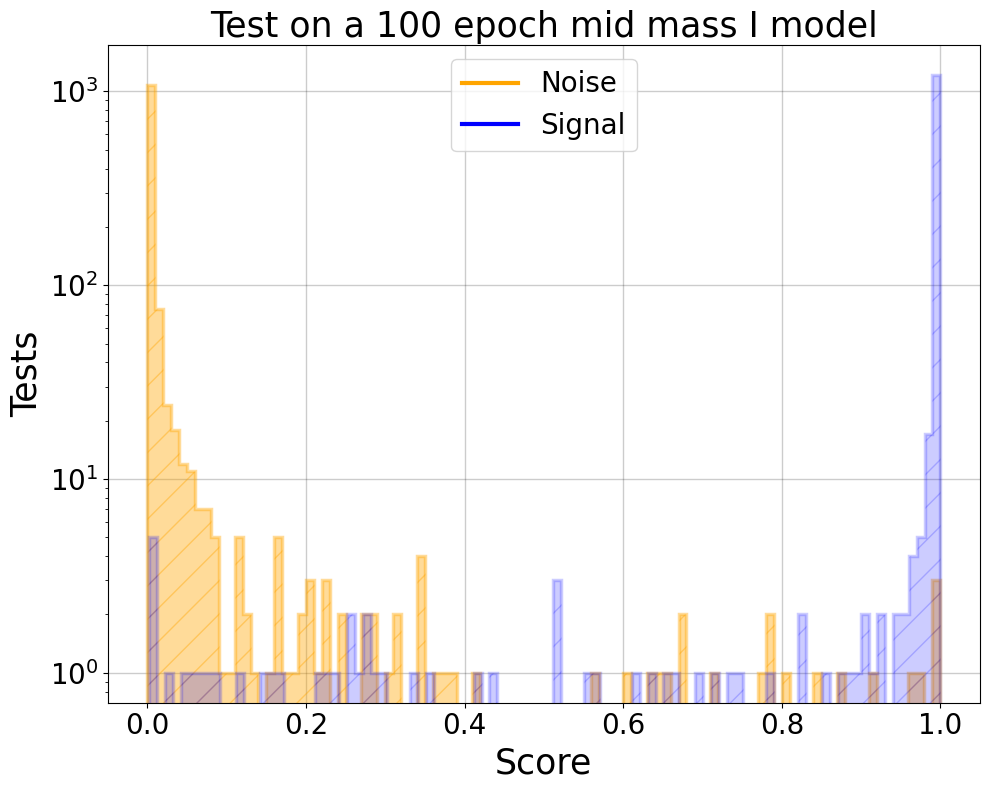

In [68]:
plot_tp_fp(y_test_pred, title='Test metrics on a 100 epoch mid mass I model')
plot_signal_noise(y_test_pred, title='Test on a 100 epoch mid mass I model')

## Mid mass II Model 

In [15]:
mass_range = "CNN_mid_mass_II"

train_path = f"{root_dir}/{mass_range}_train.npz"
test_path = f"{root_dir}/{mass_range}_test.npz"

with np.load(train_path, allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]

X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)

with np.load(test_path, allow_pickle=True) as data:
    X_test = data["X"]
    y_test = data["y"]


train_dataset = make_dataset(X_train, y_train, classification=True, batch_size=64)
val_dataset = make_dataset(X_val, y_val, classification=True, batch_size=64)
test_dataset = make_dataset(X_test, y_test, classification=True, batch_size=64, shuffle=False)

In [16]:
model_path = f"class_models/{mass_range}_best_model_prova.keras"
logger_path = f"class_models/training_log_{mass_range}_prova.csv"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, 
        monitor="val_acc",
        mode="max",
        save_best_only=True,
        verbose=0,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename=logger_path,
        append=False,
    )
]

In [6]:
model = build_model(reg_rate=5e-4, drop_rate=0.3)

total_steps = 5808 // 128 * 150  # Assuming 5808 training samples, batch size 64, for 50 epochs
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5,
    decay_steps=total_steps,
    alpha=1e-6
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=5.0),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), 
                       tf.keras.metrics.TruePositives(name="true_positives"),
                       tf.keras.metrics.FalsePositives(name="false_positives"),
                       tf.keras.metrics.Recall(name="recall")])

/home/alberto_sinigaglia/anaconda3/envs/gaia/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
'''
history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1,
)
'''

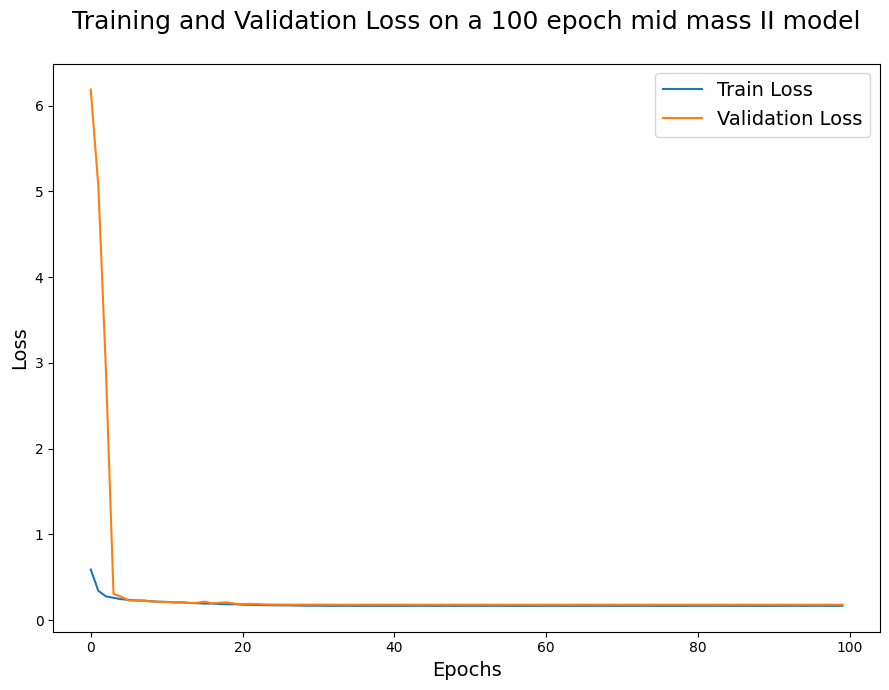

In [90]:
logger = pd.read_csv(logger_path)
train_loss = logger['loss'].values
val_loss = logger['val_loss'].values

plt.figure(figsize=(9,7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.title('Training and Validation Loss on a 100 epoch mid mass II model',
          fontsize=18, pad=25)

plt.legend(fontsize=14, loc='best')

plt.tight_layout()
plt.show()

In [17]:
model = tf.keras.models.load_model(model_path)

y_test_pred = model.predict(X_test)
pred = (y_test_pred > 0.5).astype(int)

#loss, acc, tp, fp, recall = model.evaluate(test_dataset)
acc = sklearn.metrics.accuracy_score(y_test[:,0].astype(np.float64), pred)
precision = sklearn.metrics.precision_score(y_test[:,0].astype(np.float64), pred)
recall = sklearn.metrics.recall_score(y_test[:,0].astype(np.float64), pred)
roc_auc = sklearn.metrics.roc_auc_score(y_test[:,0].astype(np.float64), y_test_pred)

print('Test Accuracy: {:.2f}%'.format(acc * 100))
print('Test Precision: {:.2f}%'.format(precision * 100))
print('Test Recall: {:.2f}%'.format(recall * 100))
print('Test ROC AUC: {:.4f}'.format(roc_auc))

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test Accuracy: 99.81%
Test Precision: 99.77%
Test Recall: 99.85%
Test ROC AUC: 1.0000


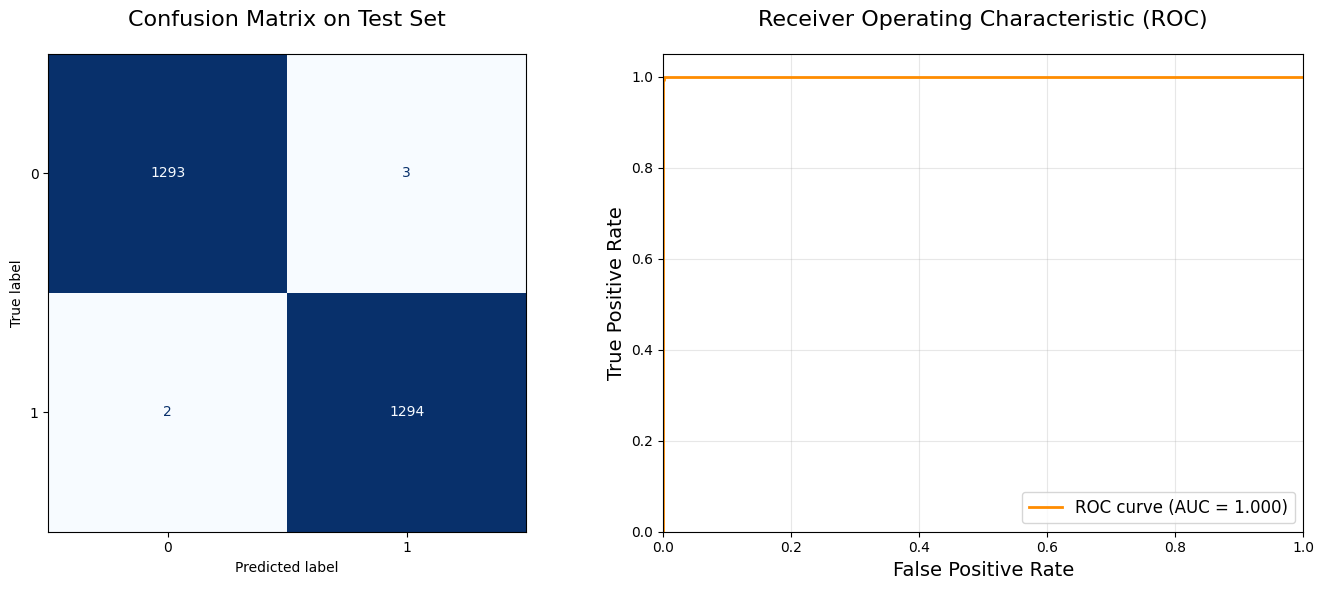

In [18]:
cm = sklearn.metrics.confusion_matrix(y_test[:,0].astype(np.float64), pred)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test[:,0].astype(np.float64), y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix on Test Set', fontsize=16, pad=20)


axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=14)
axes[1].set_ylabel('True Positive Rate', fontsize=14)
axes[1].set_title('Receiver Operating Characteristic (ROC)', fontsize=16, pad=20)
axes[1].legend(loc='lower right', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

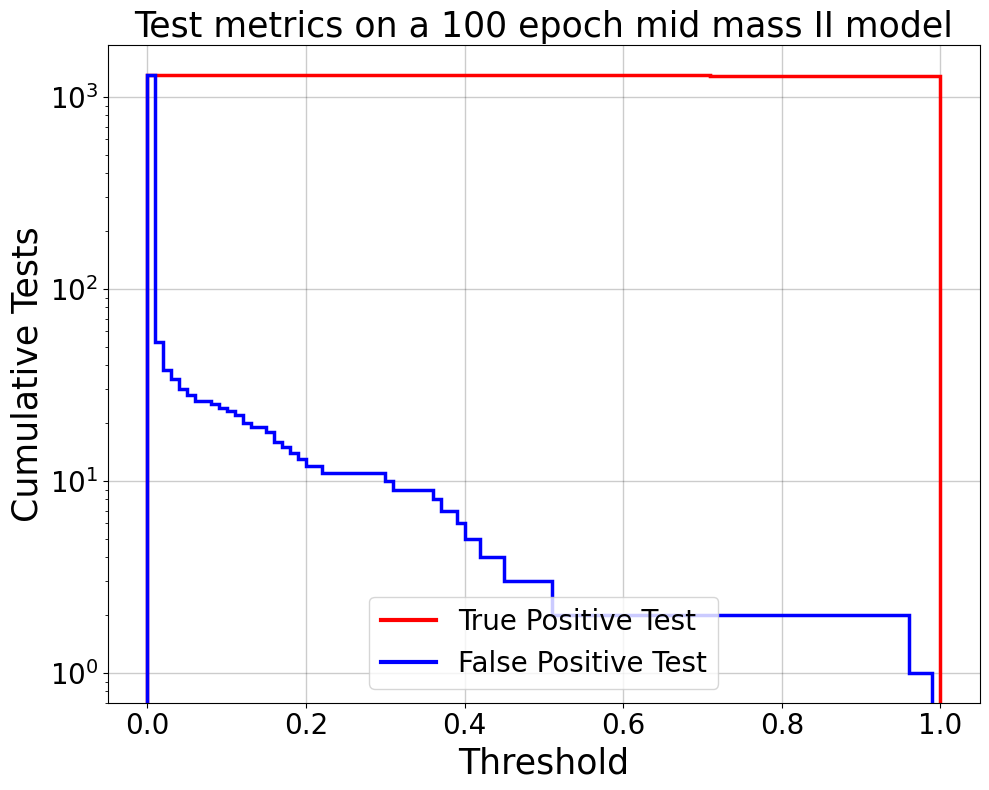

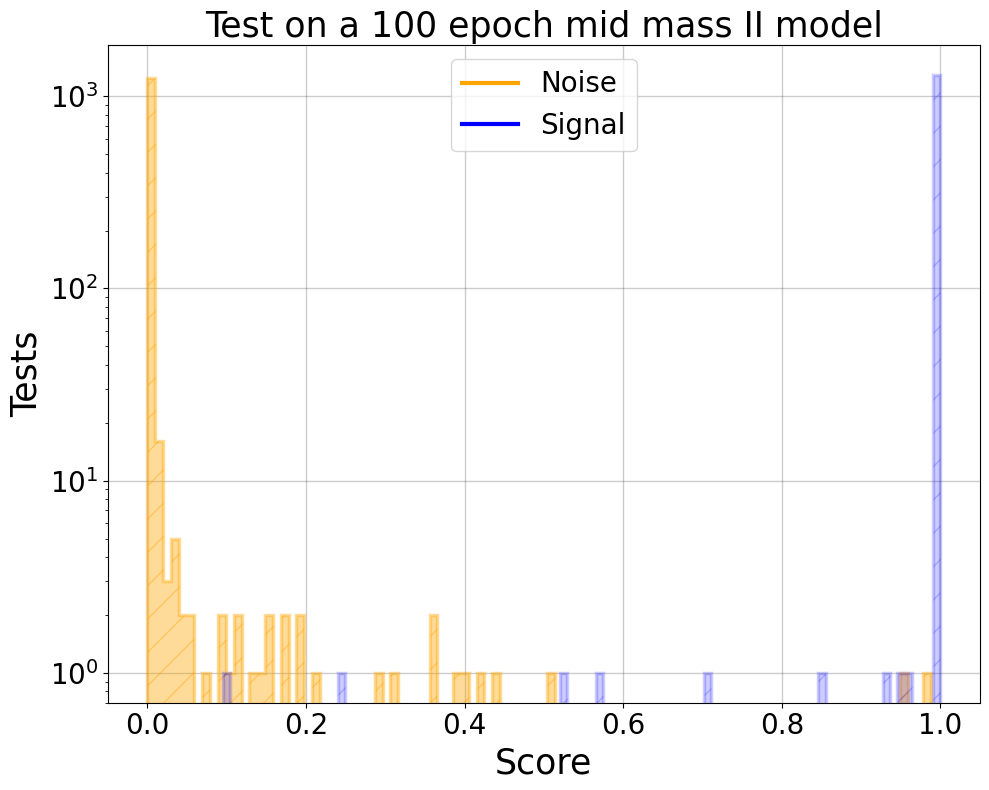

In [ ]:
plot_tp_fp(y_test_pred, title='Test metrics on a 100 epoch mid mass II model')
plot_signal_noise(y_test_pred, title='Test on a 100 epoch mid mass II model')

## High mass Model

In [3]:
mass_range = "CNN_high_mass"

train_path = f"{root_dir}/{mass_range}_train.npz"
test_path = f"{root_dir}/{mass_range}_test.npz"

with np.load(train_path, allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]

X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)

with np.load(test_path, allow_pickle=True) as data:
    X_test = data["X"]
    y_test = data["y"]


train_dataset = make_dataset(X_train, y_train, classification=True, batch_size=64)
val_dataset = make_dataset(X_val, y_val, classification=True, batch_size=64)
test_dataset = make_dataset(X_test, y_test, classification=True, batch_size=64, shuffle=False)

In [4]:
model_path = f"class_models/{mass_range}_best_model.keras"
logger_path = f"class_models/training_log_{mass_range}.csv"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, 
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=0,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename=logger_path,
        append=False,
    )
]

In [48]:
model = build_model(reg_rate=1e-4, drop_rate=0.3)

total_steps = 5808 // 128 * 150  # Assuming 5808 training samples, batch size 64, for 50 epochs
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5,
    decay_steps=total_steps,
    alpha=1e-6
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=5.0),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), 
                       tf.keras.metrics.TruePositives(name="true_positives"),
                       tf.keras.metrics.FalsePositives(name="false_positives"),
                       tf.keras.metrics.Recall(name="recall")])

/home/alberto_sinigaglia/anaconda3/envs/gaia/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
'''
history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1,
)
'''

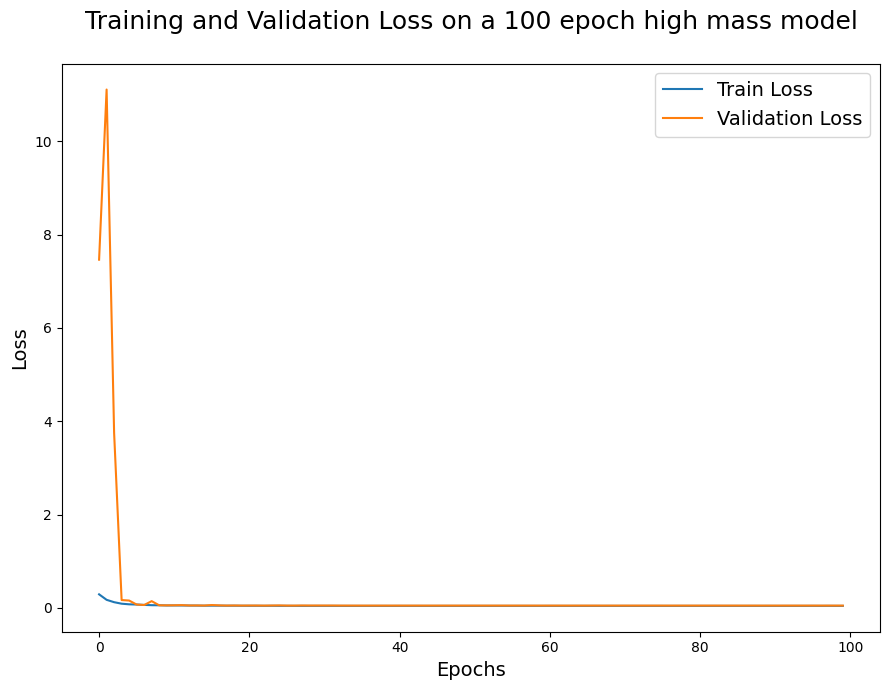

In [94]:
logger = pd.read_csv(logger_path)
train_loss = logger['loss'].values
val_loss = logger['val_loss'].values

plt.figure(figsize=(9,7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.title('Training and Validation Loss on a 100 epoch high mass model',
          fontsize=18, pad=25)

plt.legend(fontsize=14, loc='best')

plt.tight_layout()
plt.show()

In [5]:
model = tf.keras.models.load_model(model_path)
y_test_pred = model.predict(X_test)
pred = (y_test_pred > 0.8).astype(int)

#loss, acc, tp, fp, recall = model.evaluate(test_dataset)
acc = sklearn.metrics.accuracy_score(y_test[:,0].astype(np.float64), pred)
precision = sklearn.metrics.precision_score(y_test[:,0].astype(np.float64), pred)
recall = sklearn.metrics.recall_score(y_test[:,0].astype(np.float64), pred)
roc_auc = sklearn.metrics.roc_auc_score(y_test[:,0].astype(np.float64), y_test_pred)

print('Test Accuracy: {:.2f}%'.format(acc * 100))
print('Test Precision: {:.2f}%'.format(precision * 100))
print('Test Recall: {:.2f}%'.format(recall * 100))
print('Test ROC AUC: {:.4f}'.format(roc_auc))

27/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

I0000 00:00:1762351350.745461 1134729 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Test Accuracy: 99.96%
Test Precision: 99.92%
Test Recall: 100.00%
Test ROC AUC: 1.0000


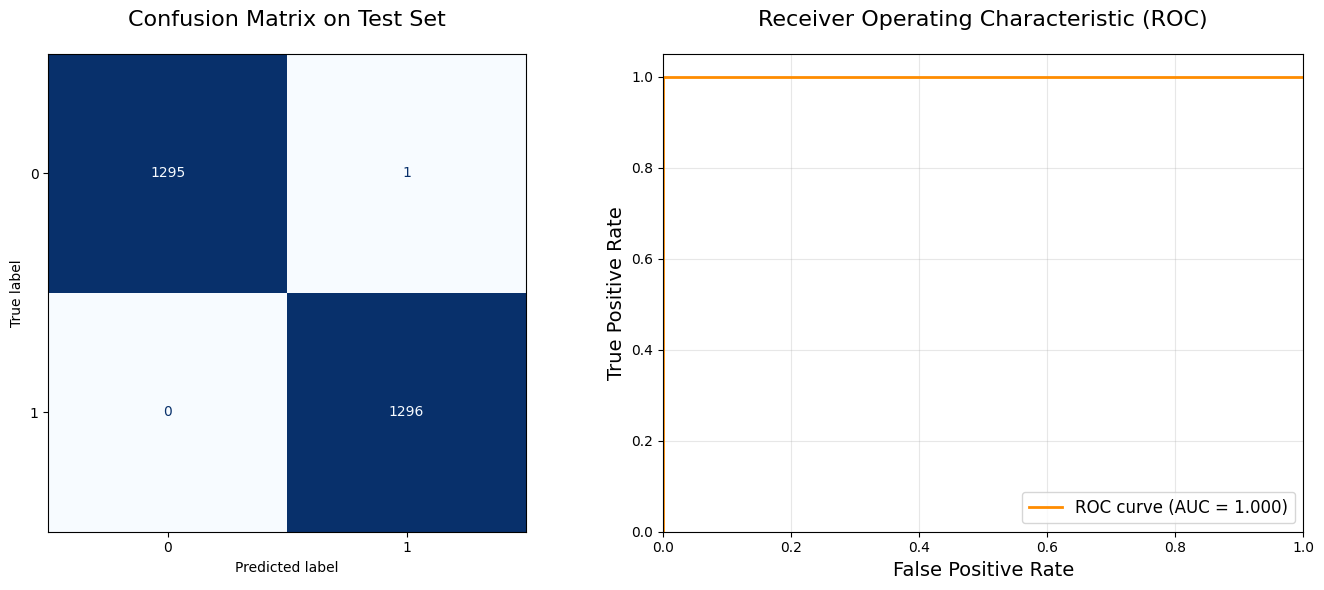

In [6]:
cm = sklearn.metrics.confusion_matrix(y_test[:,0].astype(np.float64), pred)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test[:,0].astype(np.float64), y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix on Test Set', fontsize=16, pad=20)


axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=14)
axes[1].set_ylabel('True Positive Rate', fontsize=14)
axes[1].set_title('Receiver Operating Characteristic (ROC)', fontsize=16, pad=20)
axes[1].legend(loc='lower right', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

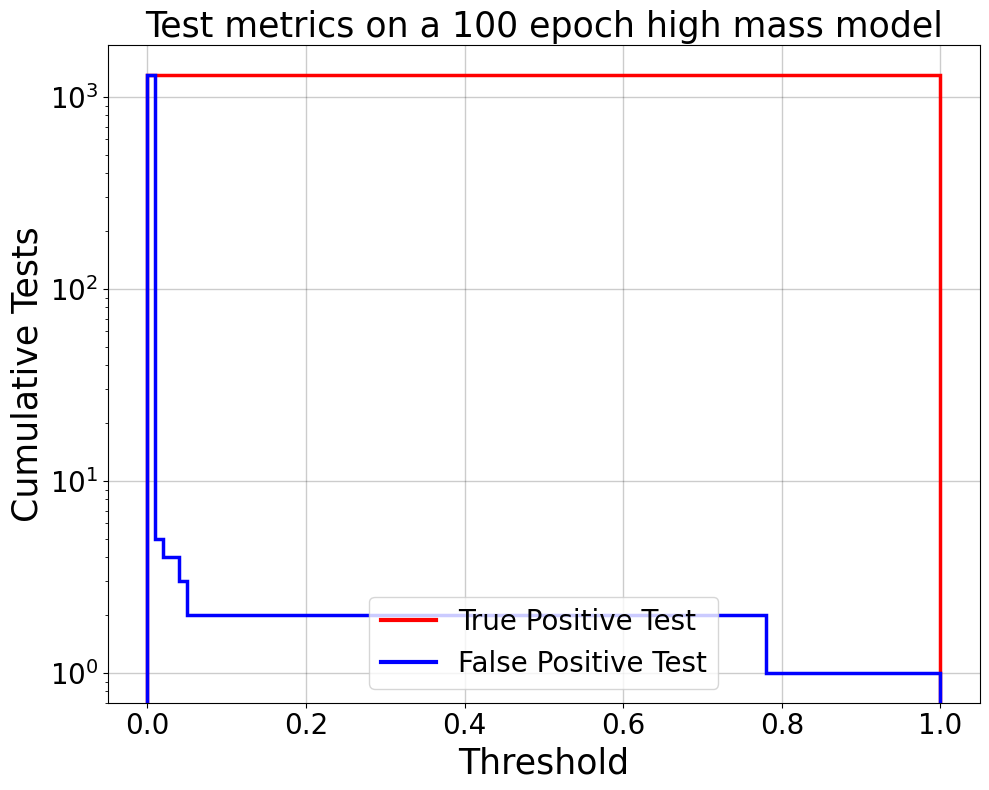

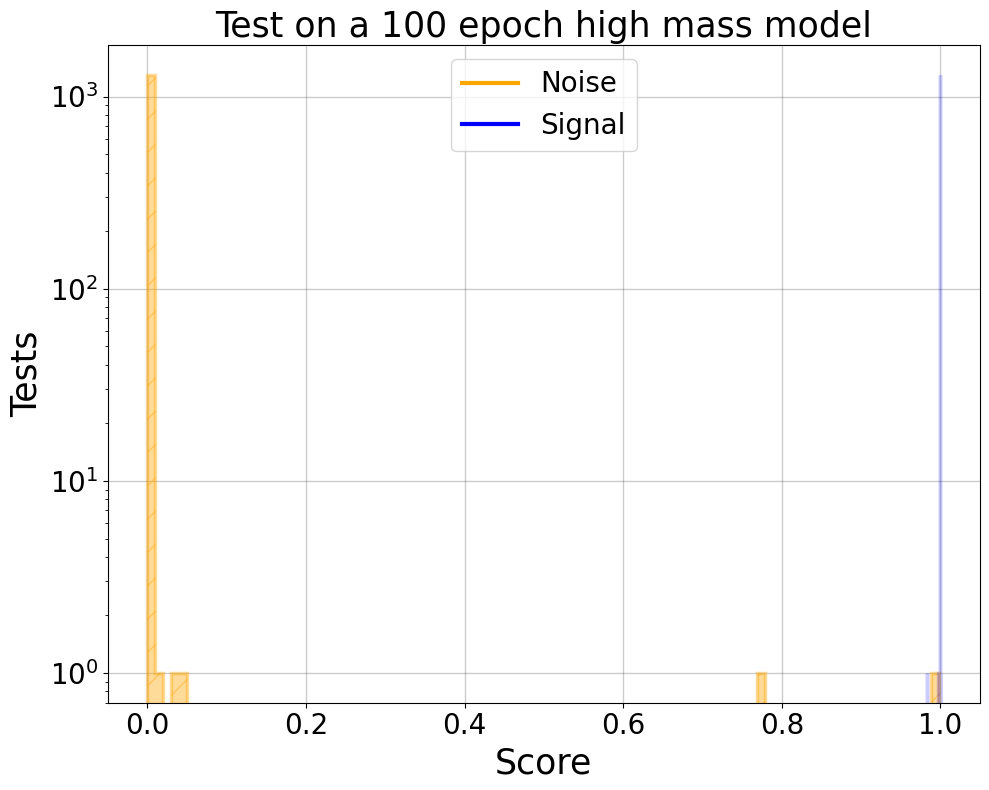

In [7]:
plot_tp_fp(y_test_pred, title='Test metrics on a 100 epoch high mass model')
plot_signal_noise(y_test_pred, title='Test on a 100 epoch high mass model')